In [1]:
%matplotlib inline
%autosave 0
%load_ext autoreload
%autoreload 2

Autosave disabled


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dtrace.DTraceUtils import rpath
import matplotlib.patches as mpatches
from dtrace.TargetHit import TargetHit
from dtrace.DTracePlot import DTracePlot
from dtrace.Associations import Association

### Import data-sets and associations

In [3]:
assoc = Association(load_associations=True, combine_lmm=True)

[2019-11-20 10:37:16,087 - INFO]: #(Samples)=484
[2019-11-20 10:37:18,018 - INFO]: #(Drugs)=480; #(Genes)=16643; #(Genomic)=519; 


## MCL1 inhibitors associations

Analysis of the significant associations between multiple MCL1 inhibitors (MCL1i) and MCL1 and MARCH5
gene-essentiality.

In [4]:
hit = TargetHit("MCL1", assoc=assoc)

### Top associations with MCL1i

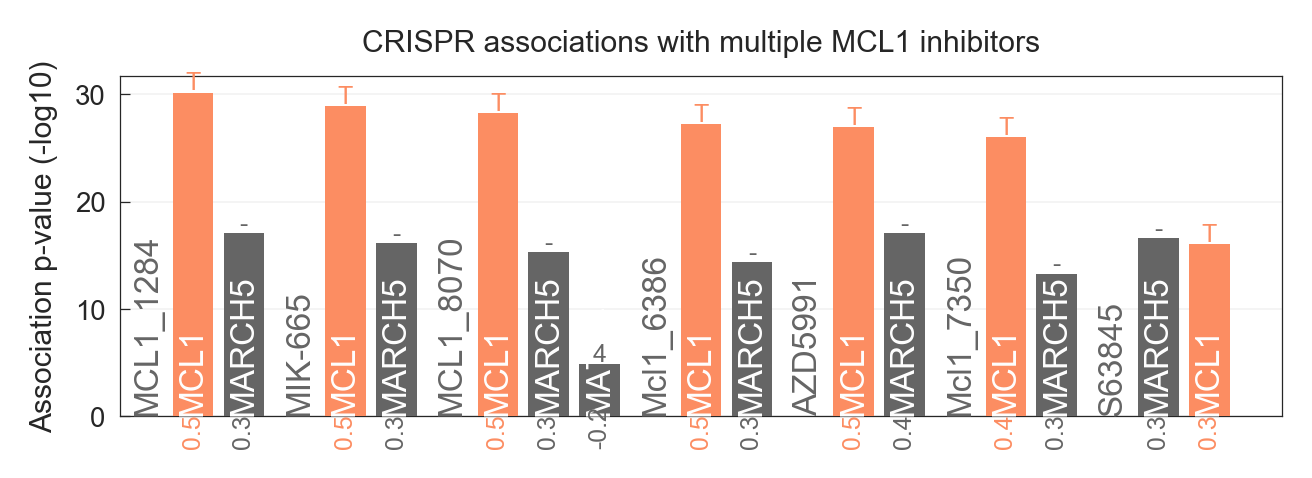

In [5]:
hit.top_associations_barplot()
plt.ylabel("Association p-value (-log10)")
plt.title("CRISPR associations with multiple MCL1 inhibitors")
plt.gcf().set_size_inches(5, 1.5)
plt.savefig(f"{rpath}/hit_topbarplot.pdf", bbox_inches="tight", transparent=True)
plt.show()

### Correlation plots of multiple MCL1i and MCL1/MARCH5

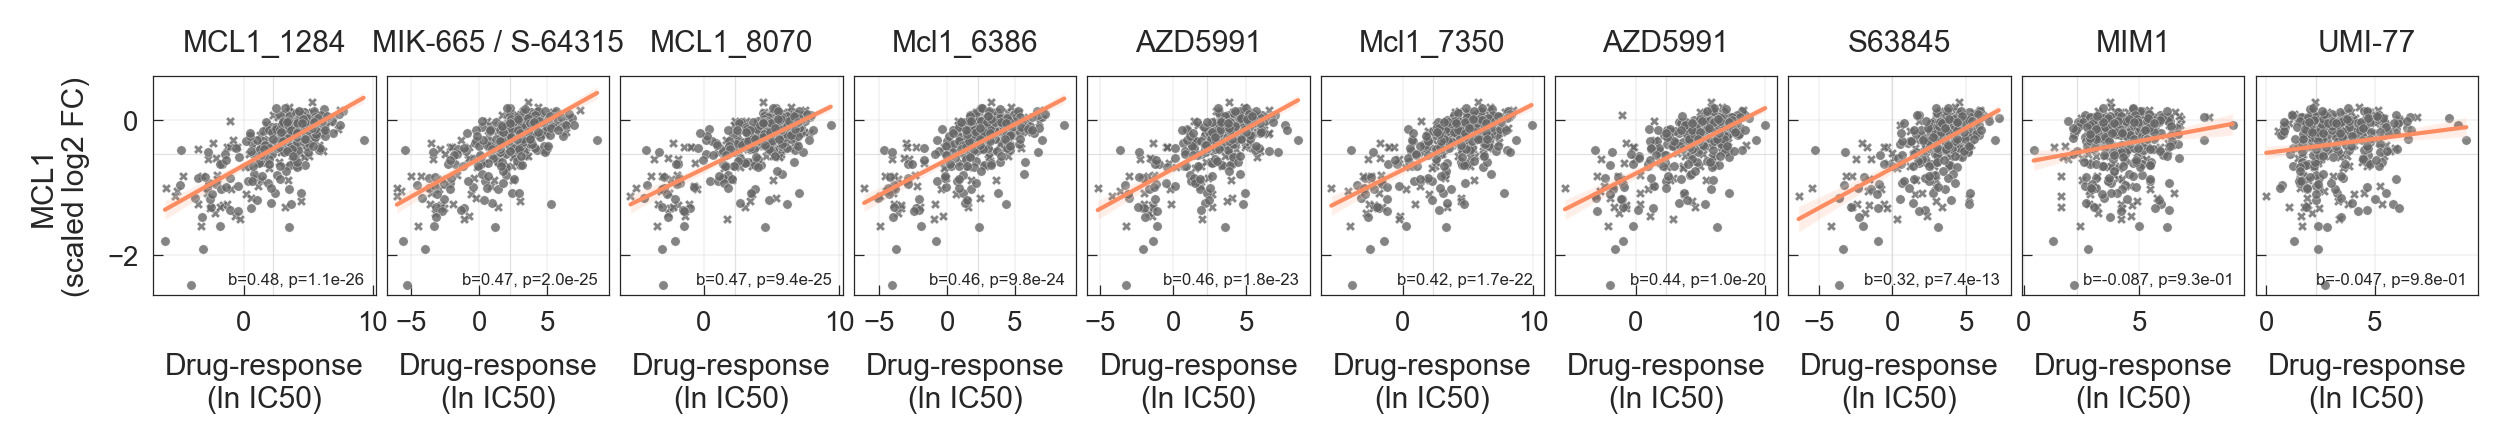

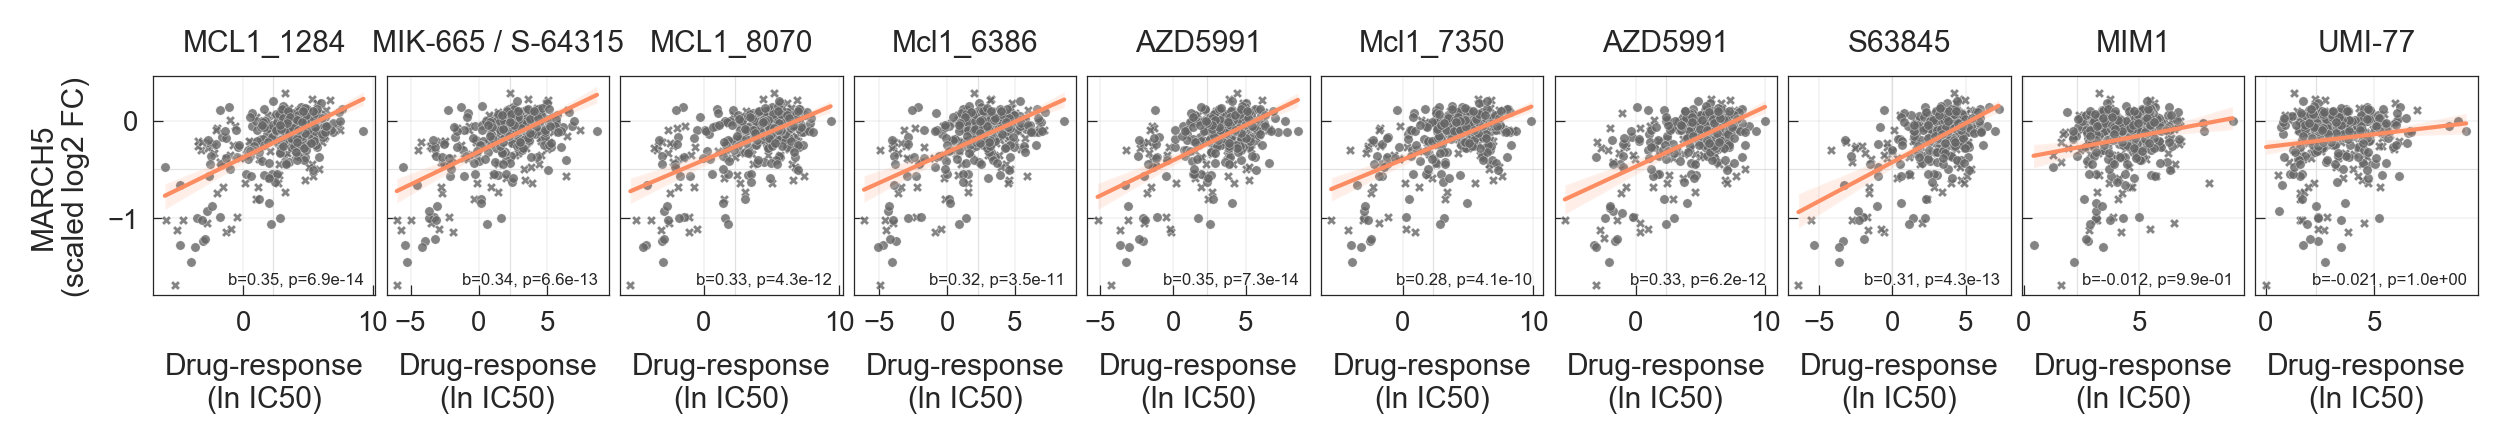

In [6]:
order = [
    tuple(d)
    for d in assoc.lmm_drug_crispr.query(
        f"(DRUG_TARGETS == 'MCL1') & (GeneSymbol == 'MCL1')"
    )[hit.dinfo].values
]
for g in ["MCL1", "MARCH5"]:
    hit.plot_target_drugs_corr(assoc, g, order=order)

    plt.savefig(
        f"{rpath}/hit_target_drugs_corr_{g}.pdf", bbox_inches="tight", transparent=True
    )
    plt.show()

### BCL inhbitors association effects

Associations effect sizes (betas) of inhibitors of BCL family members (MCL1, BCL2L1/BCL-XL and BCL2) drug-response
with gene-essentiality and gene-expression.

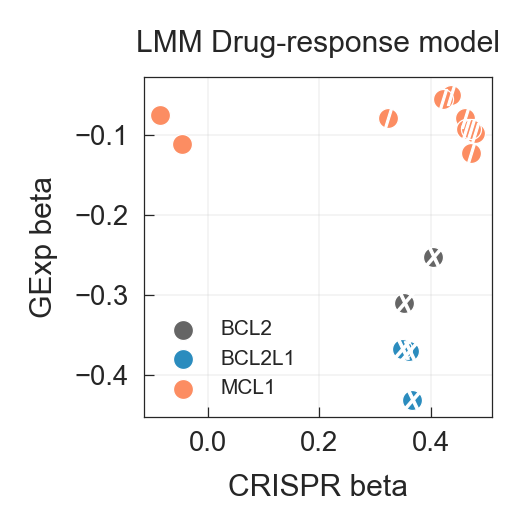

In [7]:
plt.figure(figsize=(1.5, 1.5), dpi=300)
hit.plot_drug_crispr_gexp(["MCL1", "BCL2", "BCL2L1"])
plt.savefig(f"{rpath}/hit_BCLi_crispr~gexp.pdf", bbox_inches="tight", transparent=True)
plt.show()

### MCL1i drug-response predictive features

A l2-regularised linear regression model with internal cross-validation for parameter optimisation
[RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.
RidgeCV) was used to estimate the predictive capacity [R-squared](https://scikit-learn.org/stable/modules/generated/
sklearn.metrics.r2_score.html) of MCL1i drug-response and the features contribution.

Both gene-essentiality and gene-expression measurements of BCL family members and regulators, defined in features
variable, were considered.

In [8]:
features = [
    "MARCH5",
    "MCL1",
    "BCL2",
    "BCL2L1",
    "BCL2L11",
    "PMAIP1",
    "BAX",
    "BAK1",
    "BBC3",
    "BID",
    "BIK",
    "BAD",
]
drug_lms = hit.predict_drugresponse(assoc, features)
drug_lms.to_csv(f"{rpath}/hit_rsquared.csv")

ftype = CRISPR+GEXP
ftype = CRISPR
ftype = GEXP


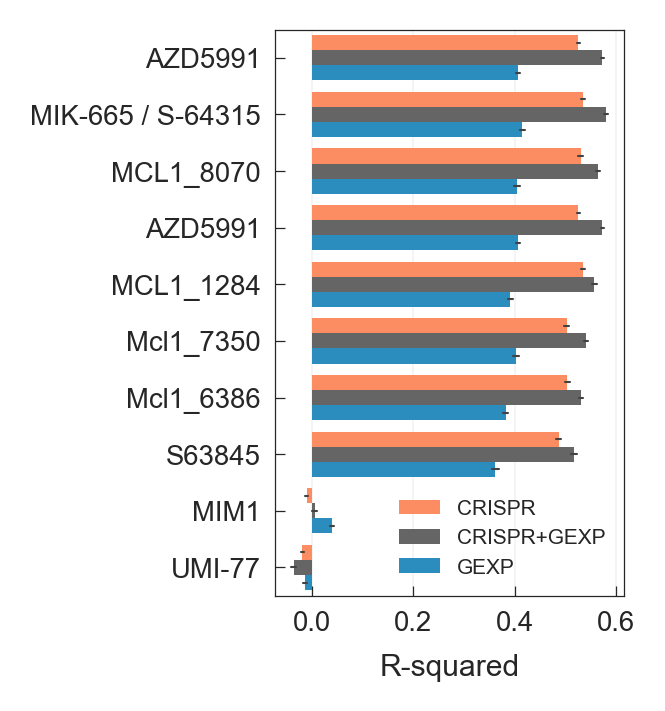

In [9]:
plt.figure(figsize=(1.5, 2.5), dpi=300)
hit.predict_r2_barplot(drug_lms)
plt.savefig(f"{rpath}/hit_rsqaured_barplot.pdf", bbox_inches="tight", transparent=True)
plt.show()

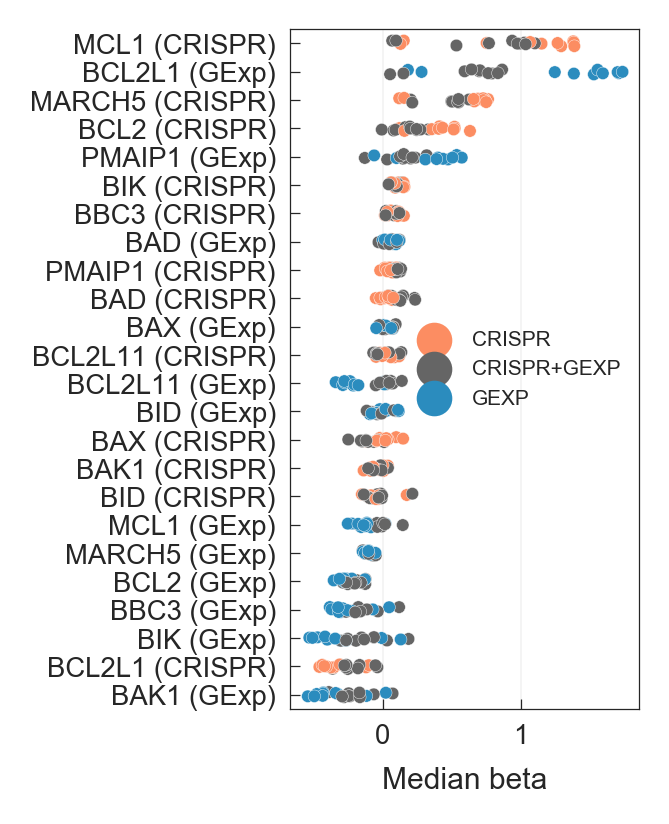

In [10]:
plt.figure(figsize=(1.5, 3), dpi=300)
hit.predict_feature_plot(drug_lms)
plt.savefig(
    f"{rpath}/hit_features_stripplot.pdf", bbox_inches="tight", transparent=True
)
plt.show()

## Stratification of MCL1i drug-response

### MCL1i inhibitors across all cell lines.

In [11]:
ctypes = ["Breast Carcinoma", "Acute Myeloid Leukemia"]
genes = ["MCL1", "MARCH5"]
order = ["None", "MARCH5", "MCL1", "MCL1 + MARCH5"]
hue_order = [
    "Other",
    "Breast Carcinoma",
    "Acute Myeloid Leukemia",
]

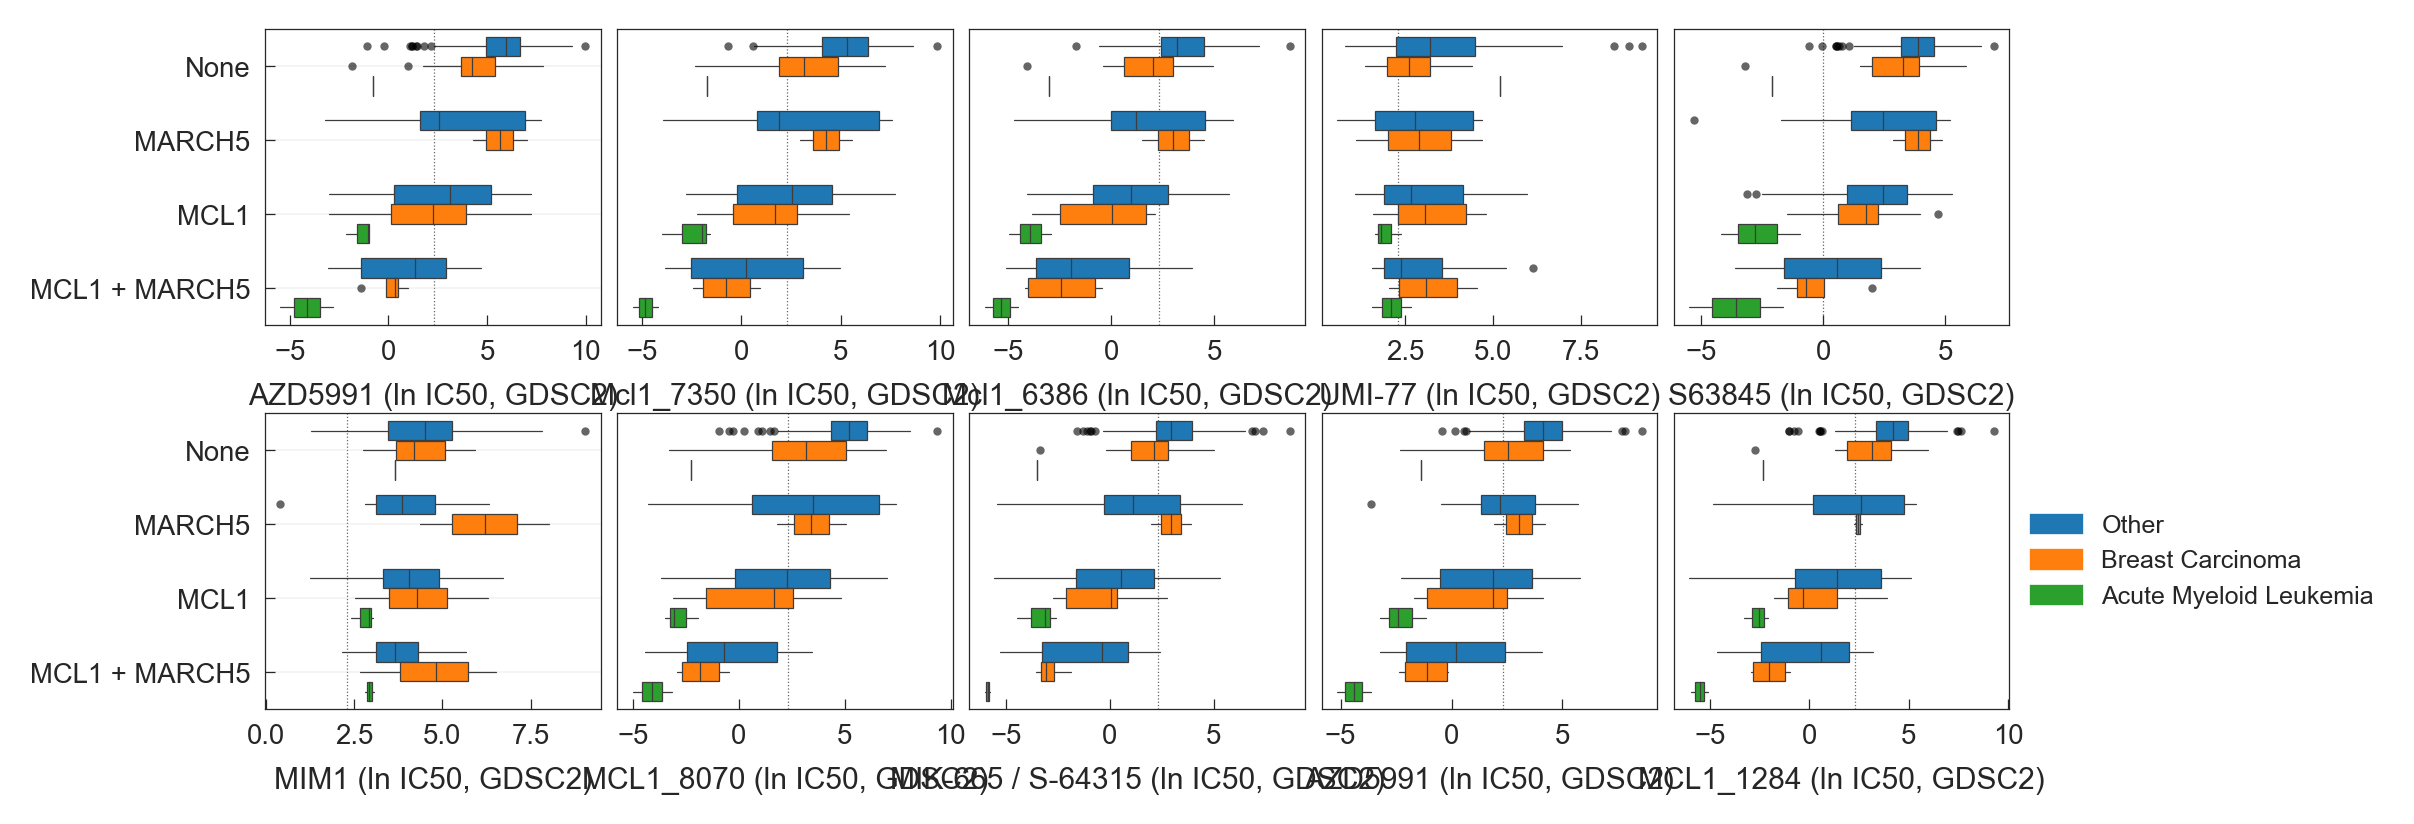

In [12]:
hit.drugresponse_boxplots(
    assoc, ctypes=ctypes, hue_order=hue_order, order=order, genes=genes
)
plt.savefig(
    f"{rpath}/hit_drugresponse_boxplot.pdf", bbox_inches="tight", transparent=True
)
plt.show()

### Drug-response of highly selective MCL1i (MCL1_1284 and AZD5991) in breast and colorectal carcinomas.

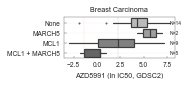

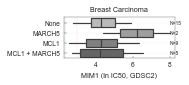

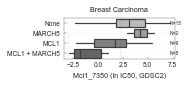

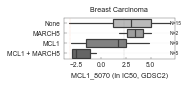

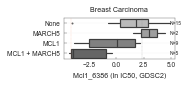

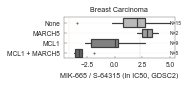

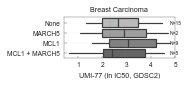

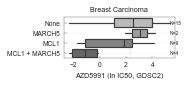

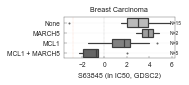

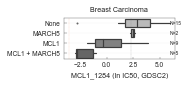

In [13]:
for drug in hit.drugs:
    # Build dataframe
    plot_df = assoc.build_df(
        drug=[drug], crispr=genes, crispr_discretise=True, sinfo=["cancer_type"]
    ).dropna()
    plot_df["ctype"] = plot_df["cancer_type"].apply(
        lambda v: v if v in ctypes else "Other"
    )
    plot_df = plot_df.rename(columns={drug: "drug"})

    # Vertical lines
    d_aml = plot_df.query("cancer_type == 'Acute Myeloid Leukemia'")["drug"].mean()
    d_max = np.log(assoc.drespo_obj.maxconcentration[drug])

    # Filter by tissue
    plot_df = plot_df[plot_df["cancer_type"] == "Breast Carcinoma"]

    # Plot
    _, ax = plt.subplots(1, 1)

    g = DTracePlot().plot_multiple(
        "drug", "crispr", plot_df, n_offset=1, n_fontsize=5, order=order, ax=ax
    )

    ax.grid(True, ls="-", lw=0.1, alpha=1.0, zorder=0, axis="y")

    for x, c in [(d_aml, 0), (d_max, 2)]:
        ax.axvline(
            x, linewidth=0.3, color=DTracePlot.PAL_DTRACE[c], ls=":", zorder=2
        )

    ax.set_xlabel(f"{drug[1]} (ln IC50, {drug[2]})")
    ax.set_ylabel("")

    ax.set_title("Breast Carcinoma")

    plt.gcf().set_size_inches(2, 0.75)
    plt.savefig(
        f"{rpath}/hit_drugresponse_boxplot_tissue_{drug[1].split(' / ')[0]}.pdf",
        bbox_inches="tight",
        transparent=True,
    )
    plt.show()

### MCL1 copy-number amplification

MCL1 copy-number amplification association with drug-response of MCL1 gene-essentiality and inhibitor.

In [14]:
d, c = ("MCL1_1284", "MCL1")
drug = assoc.lmm_drug_crispr[
    (assoc.lmm_drug_crispr["DRUG_NAME"] == d)
    & (assoc.lmm_drug_crispr["GeneSymbol"] == c)
].iloc[0]

In [15]:
drug = tuple(drug[assoc.drespo_obj.DRUG_COLUMNS])
dmax = np.log(assoc.drespo_obj.maxconcentration[drug])

In [16]:
plot_df = assoc.build_df(
    drug=[drug], crispr=[c], cn=[hit.target], sinfo=["institute", "ploidy"]
)
plot_df = plot_df.rename(columns={drug: "drug"})
plot_df = plot_df.assign(
    amp=[
        assoc.cn_obj.is_amplified(c, p)
        for c, p in plot_df[["cn_MCL1", "ploidy"]].values
    ]
)

Text(0.5, 1.05, 'MCL1 amplification')

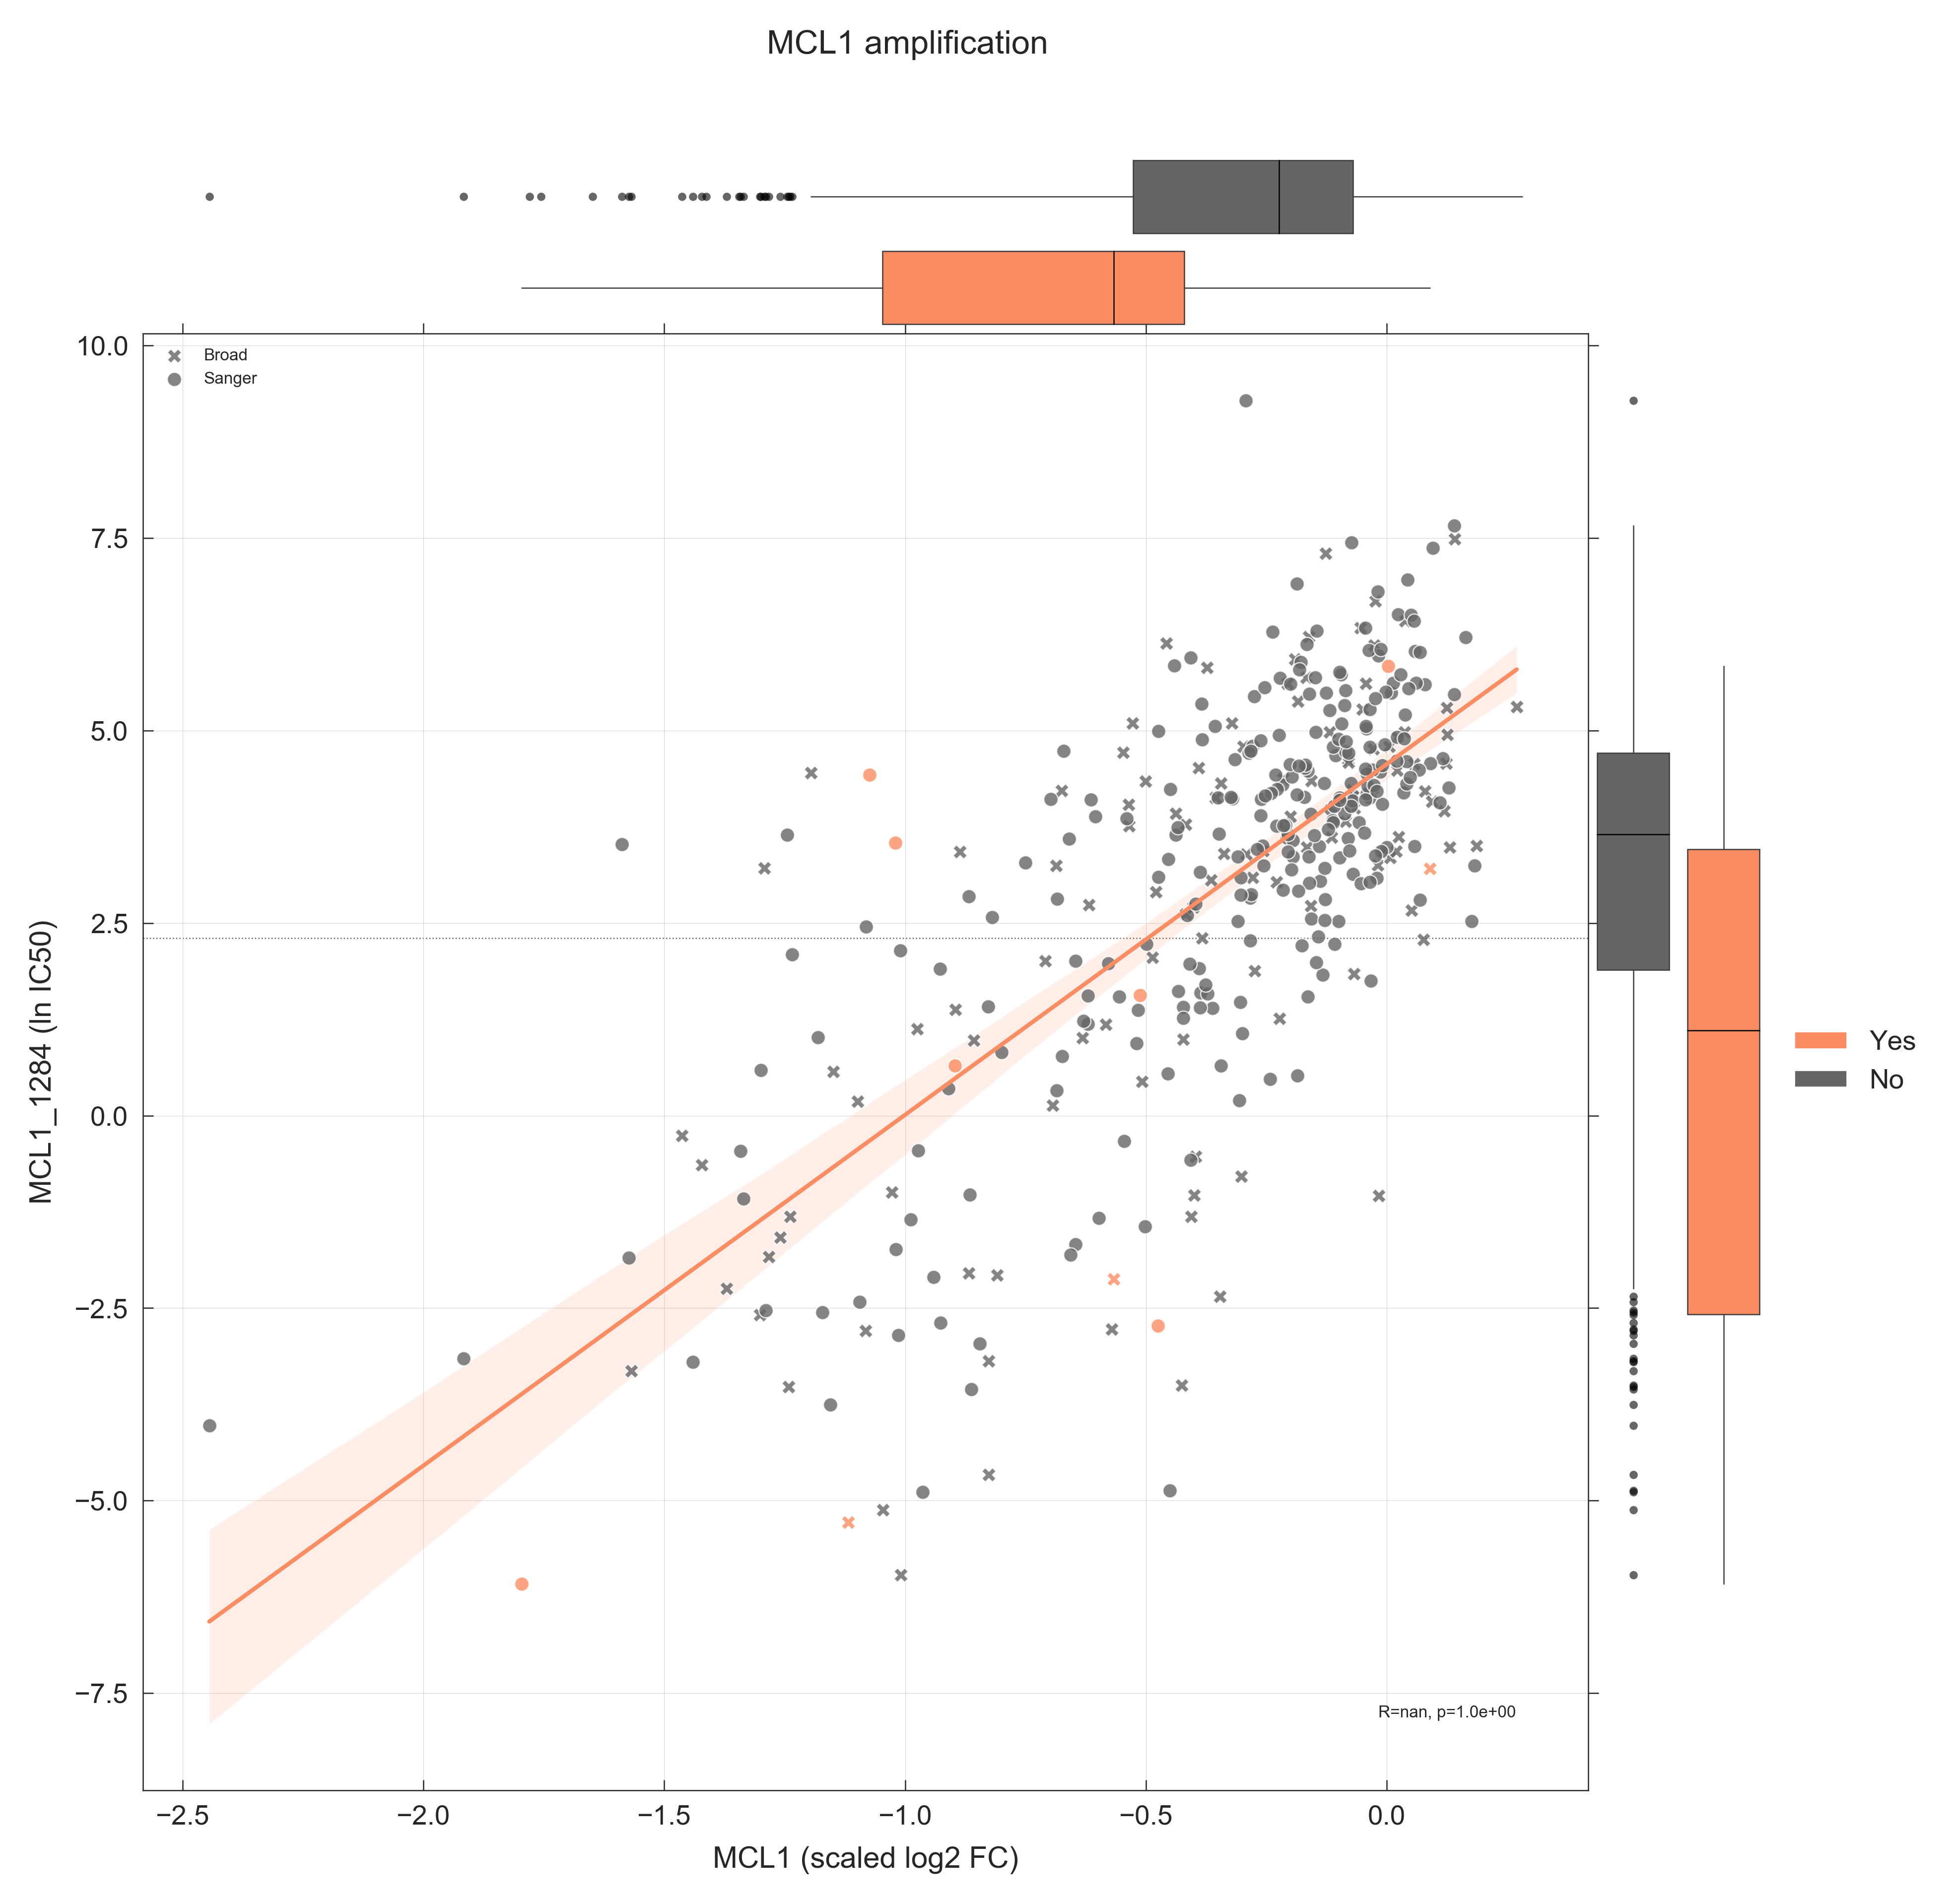

In [17]:
grid = DTracePlot.plot_corrplot_discrete(
    f"crispr_{c}", "drug", f"amp", "institute", plot_df
)
grid.ax_joint.axhline(
    y=dmax, linewidth=0.3, color=DTracePlot.PAL_DTRACE[2], ls=":", zorder=0
)
grid.set_axis_labels(f"{c} (scaled log2 FC)", f"{d} (ln IC50)")
plt.suptitle("MCL1 amplification", y=1.05, fontsize=8)

In [18]:
plt.gcf().set_size_inches(1.5, 1.5)
plt.savefig(
    f"{rpath}/hit_scatter_{d}_{c}_amp.pdf", bbox_inches="tight", transparent=True
)
plt.show()

<Figure size 108x108 with 0 Axes>

### Correlation of BCL2, BCL2L1 and MCL1 inhibitors

In [19]:
selected_targets = {"MCL1", "BCL2", "BCL2L1"}

In [20]:
d_targets = assoc.drespo_obj.get_drugtargets(by="Name")
d_targets = {
    d: d_targets[d]
    for d in d_targets
    if len(d_targets[d].intersection(selected_targets)) > 0
}
d_targets = {i: d_targets[i[1]] for i in assoc.drespo.index if i[1] in d_targets}

In [21]:
plot_df = assoc.drespo.loc[list(d_targets.keys())].T.corr()

In [22]:
pal = dict(BCL2="#fc8d62", BCL2L1="#656565", MCL1="#2b8cbe", Multiple="#32cd32")

In [23]:
row_colors = [
    pal["Multiple"] if len(d_targets[i]) > 1 else pal[list(d_targets[i])[0]]
    for i in plot_df.index
]
col_colors = [
    pal["Multiple"] if len(d_targets[i]) > 1 else pal[list(d_targets[i])[0]]
    for i in plot_df.columns
]

In [24]:
plot_df.columns = ["; ".join(d_targets[i]) for i in plot_df.columns]

Plot

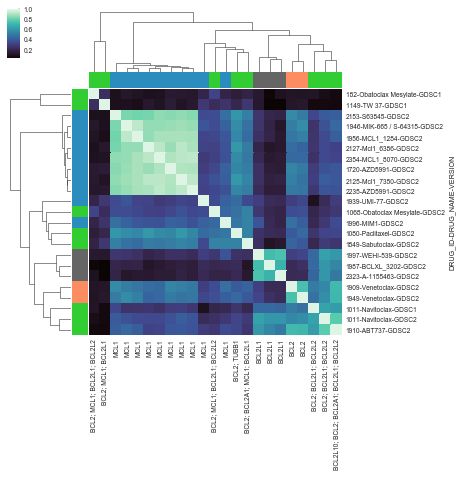

In [25]:
g = sns.clustermap(
    plot_df, figsize=(6, 6), row_colors=row_colors, col_colors=col_colors, cmap="mako"
)

In [26]:
g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)

Text(448.5, 0.5, '')

In [27]:
handles = [
    mpatches.Circle((0.0, 0.0), 0.25, facecolor=v, label=k) for k, v in pal.items()
]
g.ax_col_dendrogram.legend(handles=handles, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)

In [28]:
plt.savefig(f"{rpath}/hit_BCL2_inhbitors_clustermap.pdf", bbox_inches="tight")
plt.show()

<Figure size 432x288 with 0 Axes>

Copyright (C) 2019 Emanuel Goncalves